In [1]:
import tensorflow as tf
import modules.layers as tf_util
import modules.utility as util
import numpy as np
import tables
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

#######################################################
# Get data
#######################################################
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
train = data_path+'train_192_ct.hdf5'
val = data_path+'val_192_ct.hdf5'
test = data_path+'test_192_ct.hdf5'

f_train = tables.open_file(train)
f_val = tables.open_file(val)

input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)
print f_val.root.X.shape

Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled
(127788, 192, 192, 1) (127788, 192, 192, 1)
data shapes, train=(127788, 192, 192, 1),(127788, 192, 192, 1)
(6561, 192, 192, 1)


In [2]:
######################################################
# Define variables
######################################################
N = f_train.root.X.shape[0]
Nval = f_val.root.X.shape[0]
W,H,C = f_train.root.X[0].shape
C=1
crop_dims = 128
Nbatch = 64
lr = 1e-4
Nsteps=10000
print_step=1000
init = 6e-2

Nfilters = 32

EPS=1e-4
leaky_relu = tf.contrib.keras.layers.LeakyReLU(0.2)
y_index=0
alph = 0.3
beta = 0.7

In [3]:


def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
    return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x)-alpha)
#########################################################
# Define graph
#########################################################
x = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,crop_dims,crop_dims,C],dtype=tf.float32)

yclass,o3,o4 = tf_util.I2INet(x,nfilters=Nfilters,activation=leaky_relu,init=init)


TP = tf.reduce_sum(yclass*y)
FP = tf.reduce_sum(yclass*(1-y))
FN = tf.reduce_sum((1-yclass)*y)
loss = -TP/(TP + alph*FP+beta*FN+EPS)

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print yclass

saver = tf.train.Saver()

Tensor("conv2d/Sigmoid:0", shape=(?, 128, 128, 1), dtype=float32)


In [4]:
def get_batch(X,Y,N,n=32, gen_angles=True, crop_dims=128, offset=10):
    inds = np.random.choice(range(N),size=n, replace=False)
    x = X[inds,:,:,0].astype(np.float32)
    y = Y[inds,:,:,0].astype(np.float32)

    #rotations
    if gen_angles:
        angles = np.random.randint(360, size=x.shape[0])
        xrot = np.zeros(x.shape)
        yrot = np.zeros(y.shape)
    for i in range(len(angles)):
        xrot[i] = rotate(x[i],angles[i], axes=(1,0), reshape=False)
        yrot[i] = rotate(y[i],angles[i], axes=(1,0), reshape=False)
        
    #random crops
    space = x.shape[1]-crop_dims
    starts = np.random.randint(space-1, size=[x.shape[0],2])
    
    x = [xrot[i,starts[i,0]:starts[i,0]+crop_dims,starts[i,1]:starts[i,1]+crop_dims] for i in range(x.shape[0])]
    x = np.asarray(x)
    x = x[:,:,:,np.newaxis]
    y = [yrot[i,starts[i,0]:starts[i,0]+crop_dims,starts[i,1]:starts[i,1]+crop_dims] for i in range(y.shape[0])]
    y= np.asarray(y)
    y = y[:,:,:,np.newaxis]
    return x,y

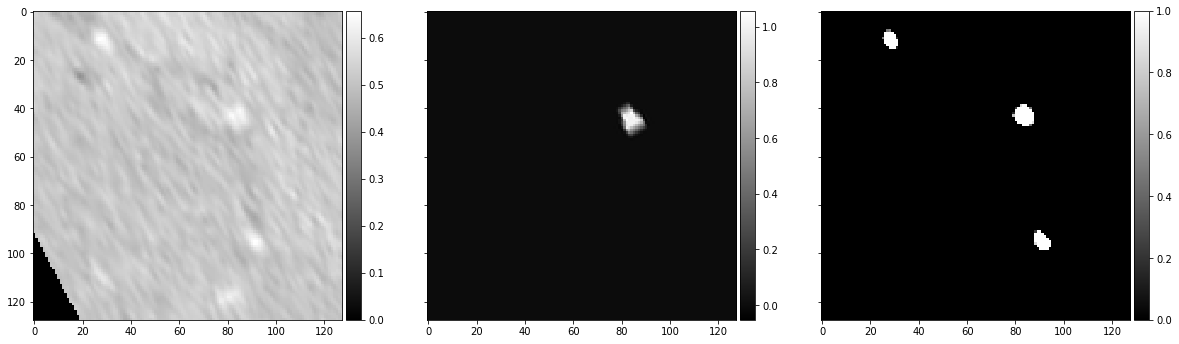

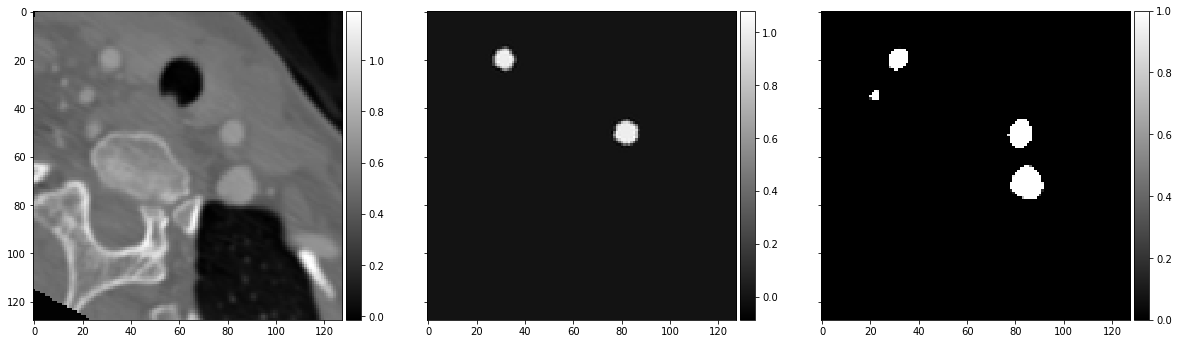

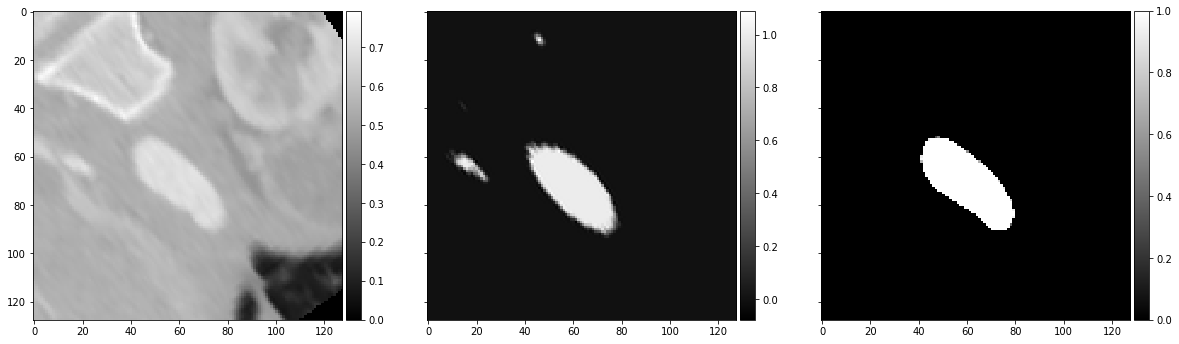

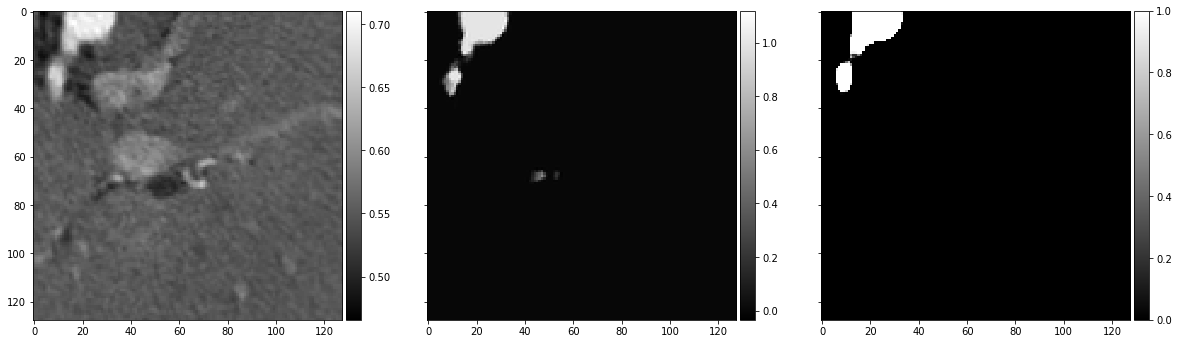

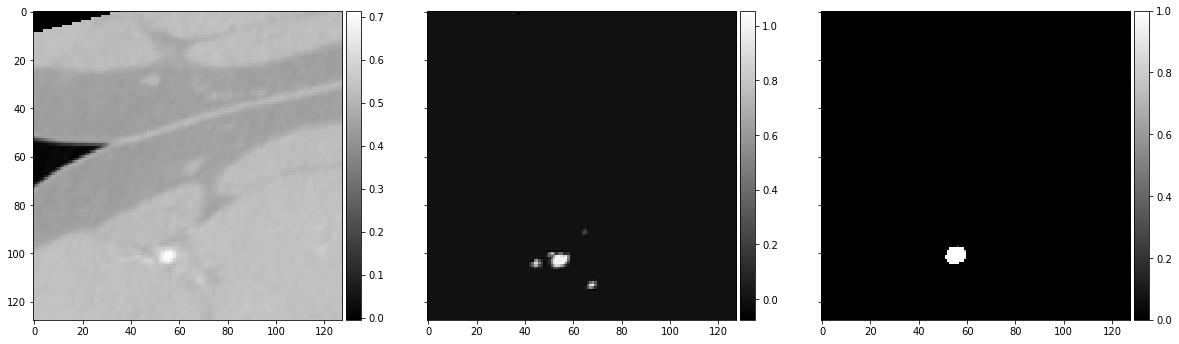

In [6]:
######################################################
# Plot
######################################################
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
xb,yb = get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,crop_dims=crop_dims)
yout =sess.run(yclass,{x:xb,y:yb})
 
for i in range(5):
    xval = xb[i:i+2]
    yval = yb[i:i+2][:,:,:,:]
    ypred = yout[i:i+2]
    
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(xval[0,:,:,0],ax1)
    implot(yval[0,:,:,0],ax2)
    implot(ypred[0,:,:,0],ax3)
    plt.tight_layout
    plt.show()

In [7]:
print xval.shape
print yval.shape
print yout.shape

(2, 128, 128, 1)
(2, 128, 128, 1)
(64, 128, 128, 1)


In [7]:
# #######################################################
# # Train positive
# #######################################################
train_hist = []
val_hist = []

for i in range(Nsteps+1):
    xb,yb = get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,crop_dims=crop_dims)
    l,_=sess.run([loss,train],{x:xb,y:yb})
    if i%(print_step)==0:
        print "iteration {}".format(i)

        xb,yb = get_batch(f_val.root.X,f_val.root.Y,Nval,Nbatch,crop_dims=crop_dims)
        lval,ypred=sess.run([loss,yclass],{x:xb,y:yb})
        print "Train: {}, Val: {}, p var {}, p mean {}, p max {}, p min {}".format(l,lval,
                np.var(ypred),np.mean(ypred), np.amax(ypred),np.amin(ypred))

        saver.save(sess,'./models/i2i/i2i')

iteration 0
Train: -0.11975479871, Val: -0.143276363611, p var 0.00684989336878, p mean 0.818743944168, p max 0.920481026173, p min 0.507363319397
iteration 1000
Train: -0.554676175117, Val: -0.62068259716, p var 0.0957705006003, p mean 0.10868024081, p max 1.0, p min 0.0
iteration 2000
Train: -0.632213056087, Val: -0.720180749893, p var 0.0757832229137, p mean 0.0839959383011, p max 1.0, p min 0.0
iteration 3000
Train: -0.776713013649, Val: -0.735199868679, p var 0.0682334378362, p mean 0.0747180208564, p max 1.0, p min 0.0
iteration 4000
Train: -0.730835080147, Val: -0.622393846512, p var 0.057621255517, p mean 0.0624547079206, p max 1.0, p min 0.0
iteration 5000
Train: -0.744983911514, Val: -0.685451209545, p var 0.0494090430439, p mean 0.0527452714741, p max 1.0, p min 0.0
iteration 6000
Train: -0.742867827415, Val: -0.778948545456, p var 0.0577614828944, p mean 0.0620356947184, p max 1.0, p min 0.0
iteration 7000
Train: -0.797966897488, Val: -0.718782484531, p var 0.0476317852736,

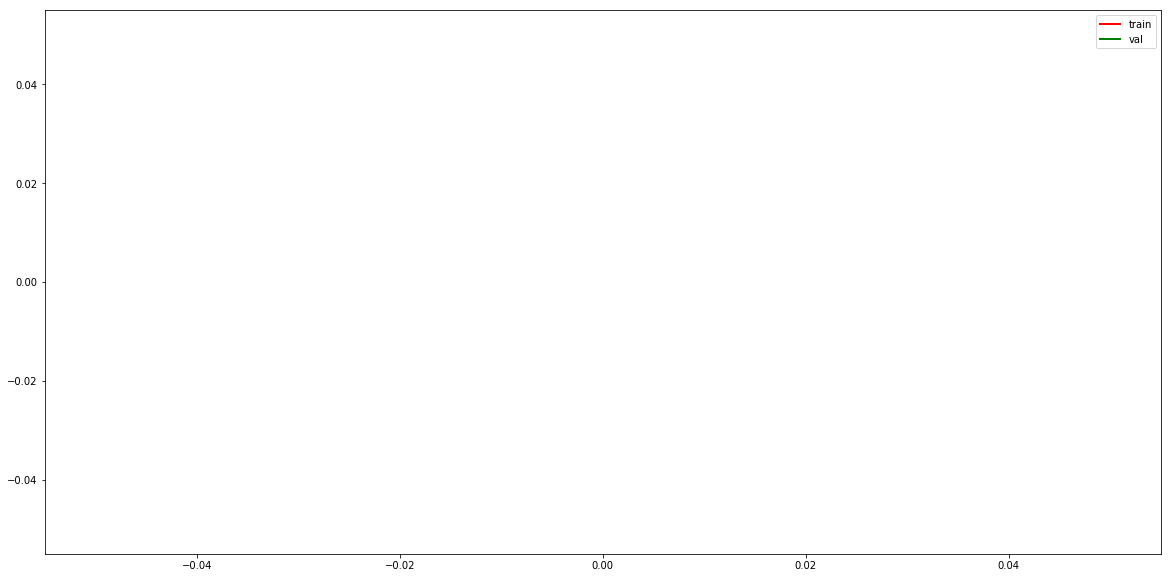

In [9]:
plt.figure()
plt.plot(train_hist, linewidth=2,color='r',label='train')
plt.plot(val_hist, linewidth=2,color='g',label='val')
plt.legend()
plt.show()

In [8]:
f_test = tables.open_file(test)

In [12]:
N=f_test.root.X.shape[0]
print N
ypred=np.zeros((N,crop_dims,crop_dims,1)).astype(float)
ytrue=np.zeros((N,crop_dims,crop_dims,1)).astype(float)

for i in range(0,N,Nbatch):
    xb = util.crop_center_nd(f_test.root.X[i:i+Nbatch], 
                                crop_dims,crop_dims)
    yb = util.crop_center_nd(f_test.root.Y[i:i+Nbatch],
                                crop_dims, crop_dims)
   
    yout =sess.run(yclass,{x:xb,y:yb})
    ypred[i:i+Nbatch] = yout
    ytrue[i:i+Nbatch] = yb

64136


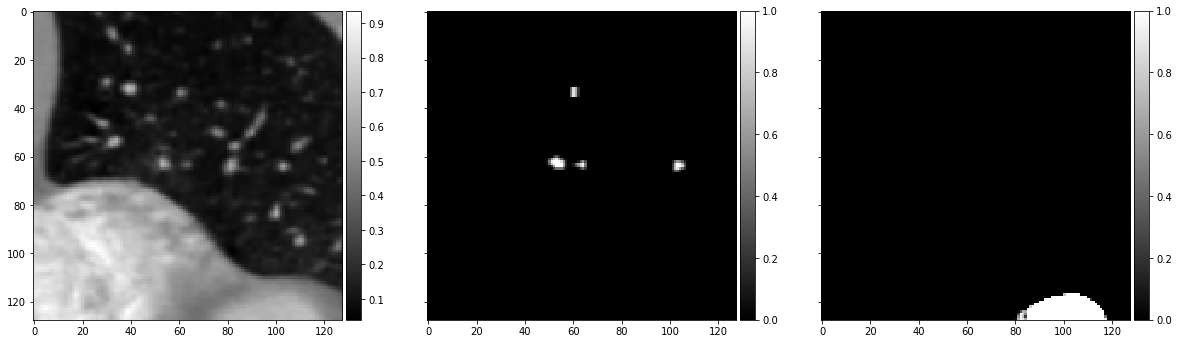

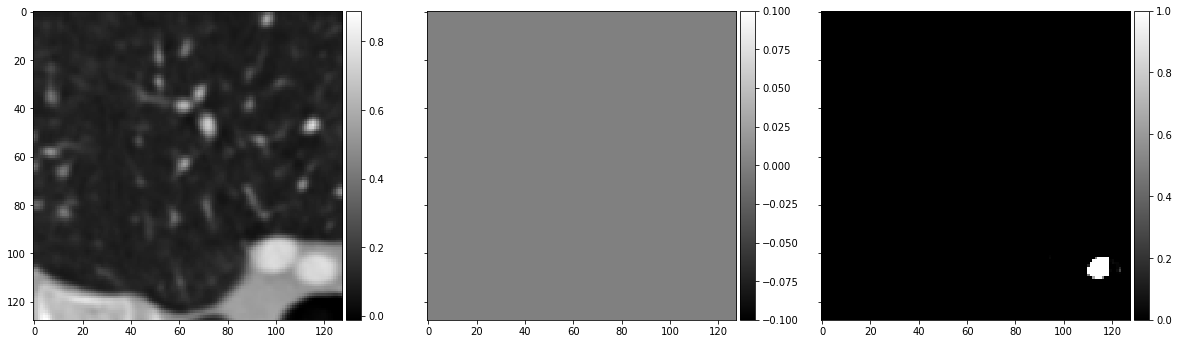

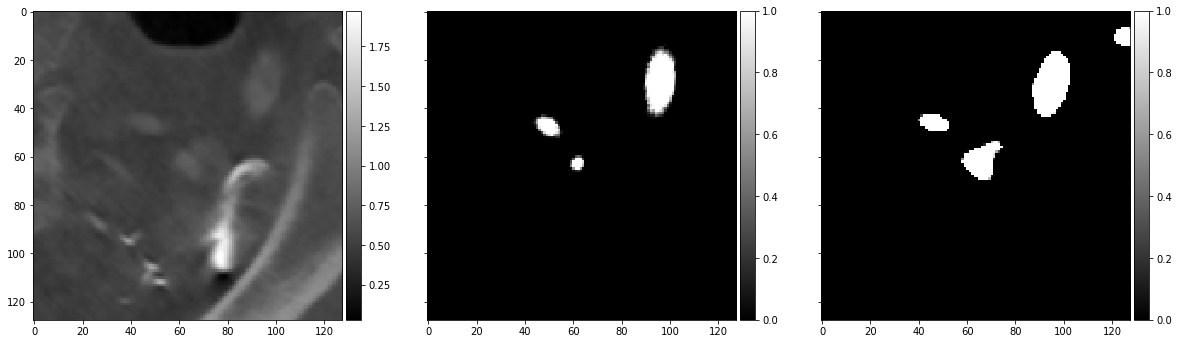

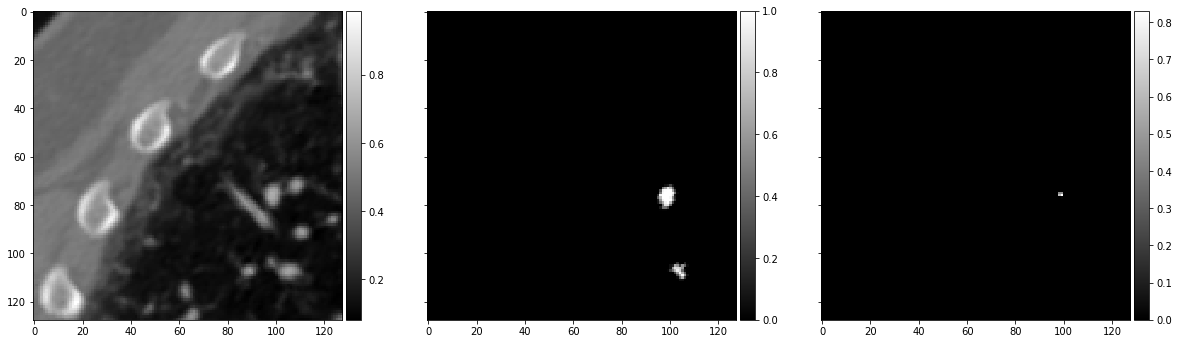

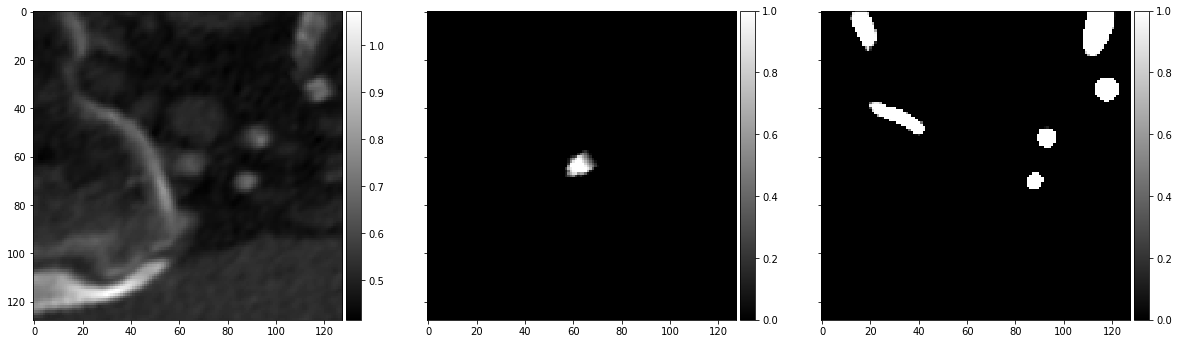

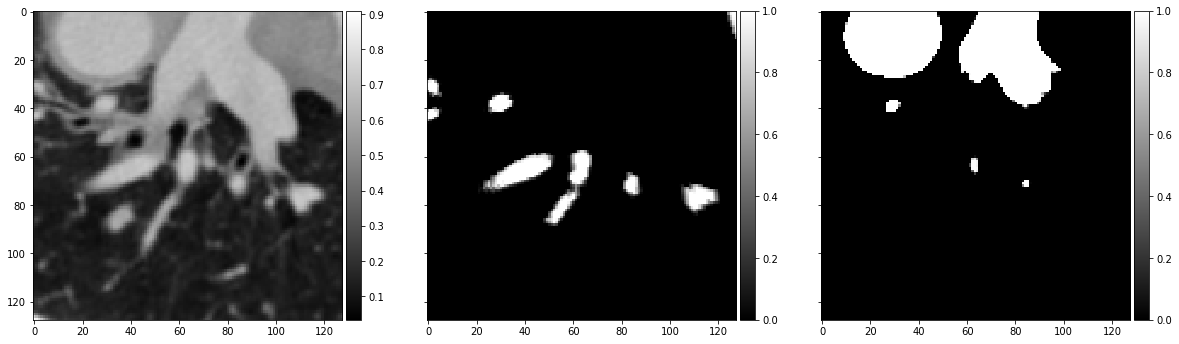

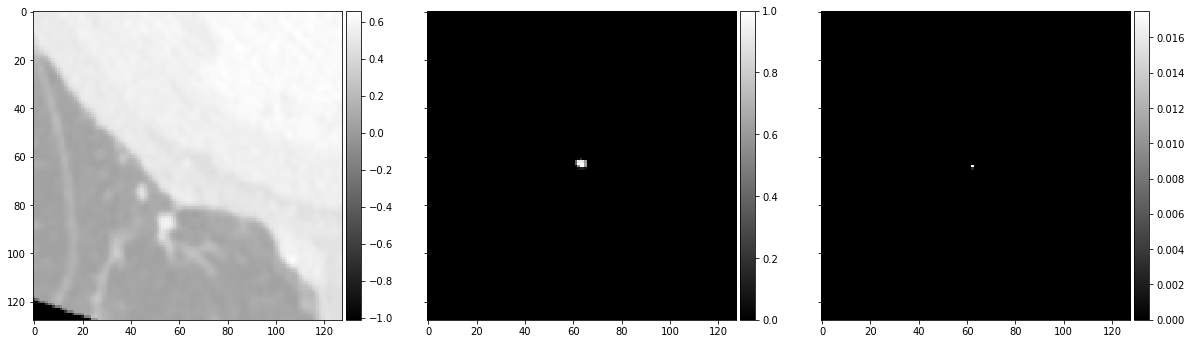

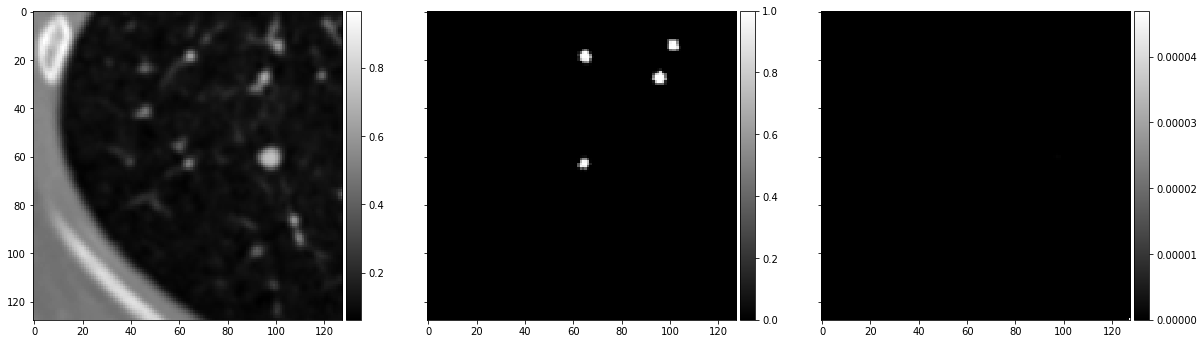

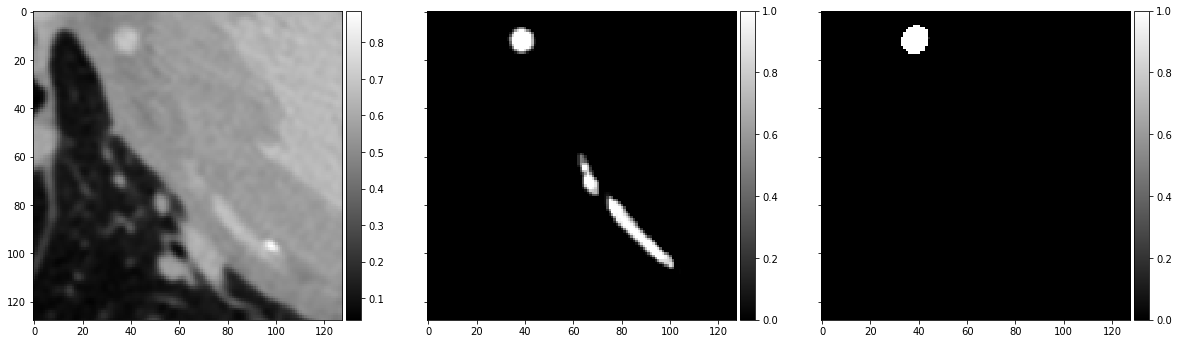

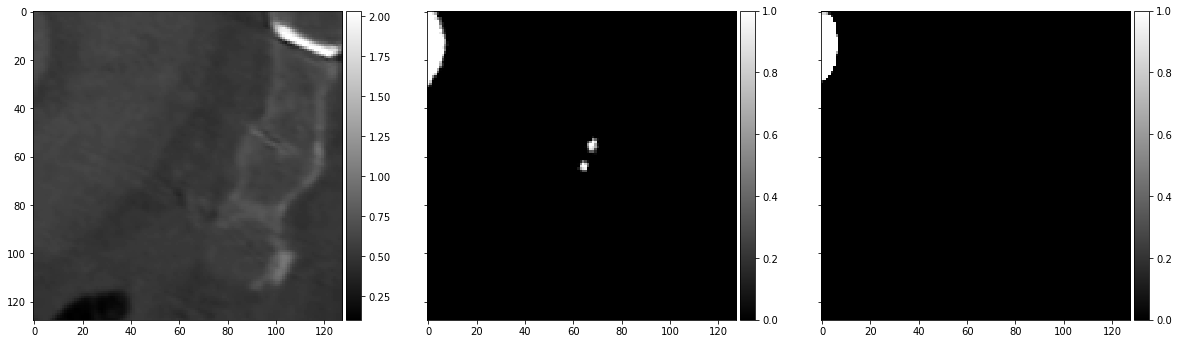

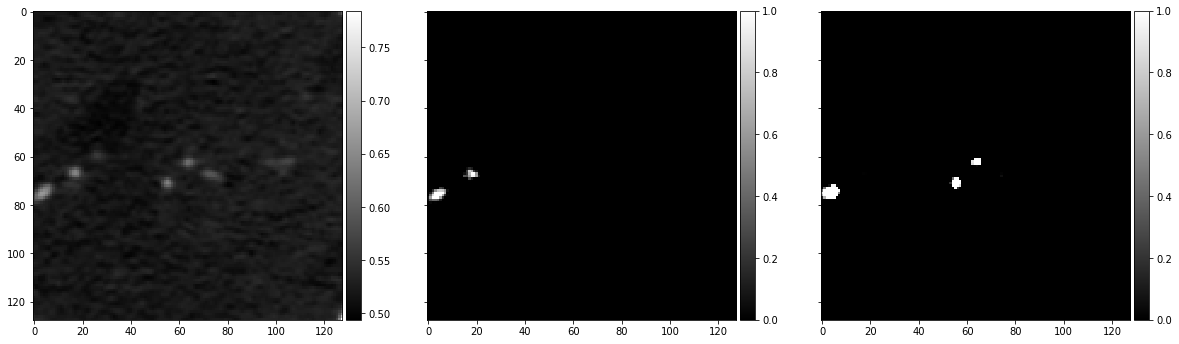

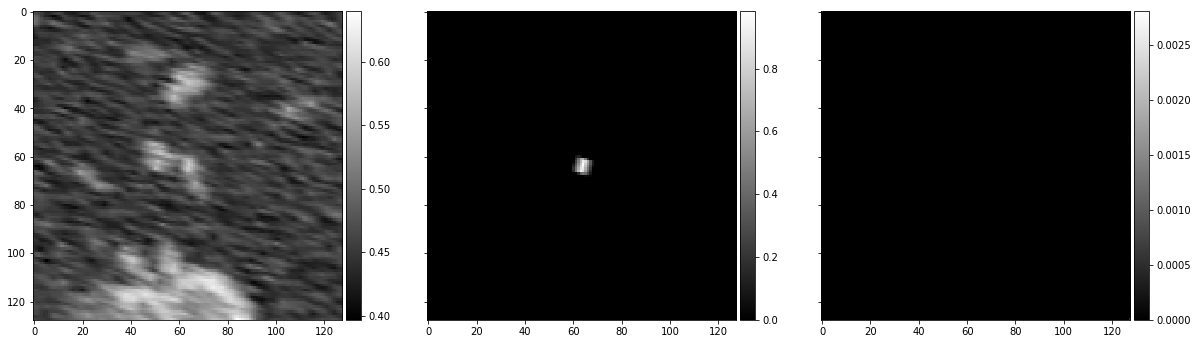

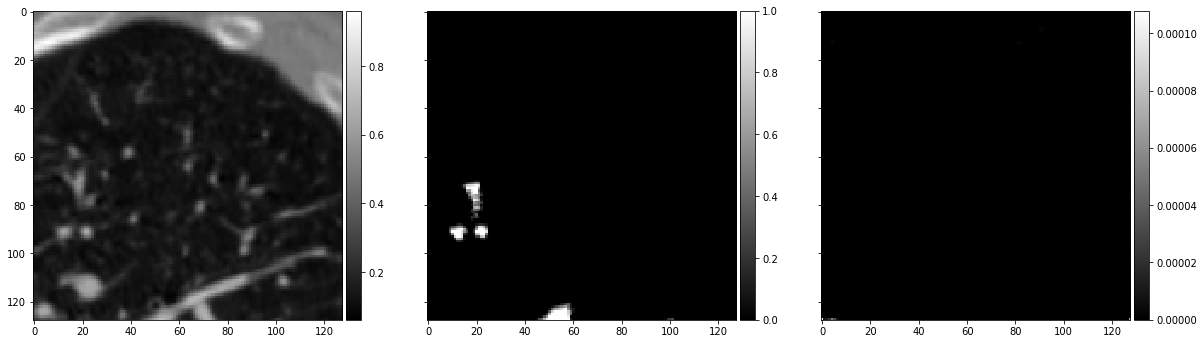

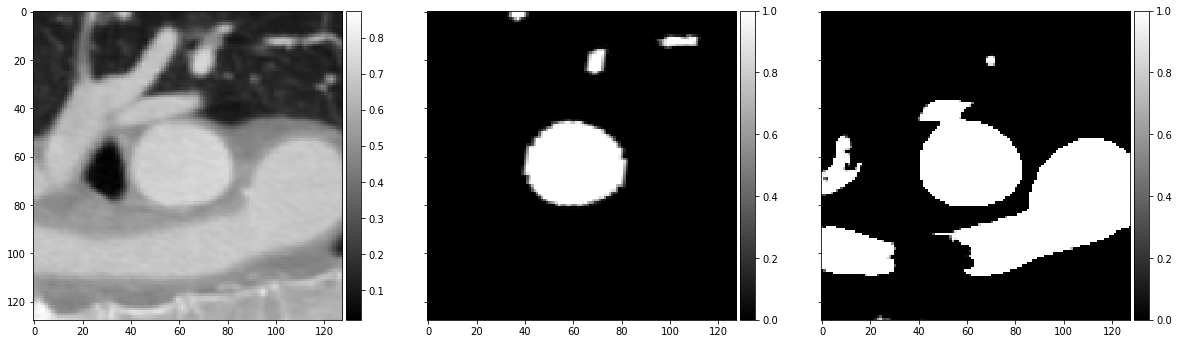

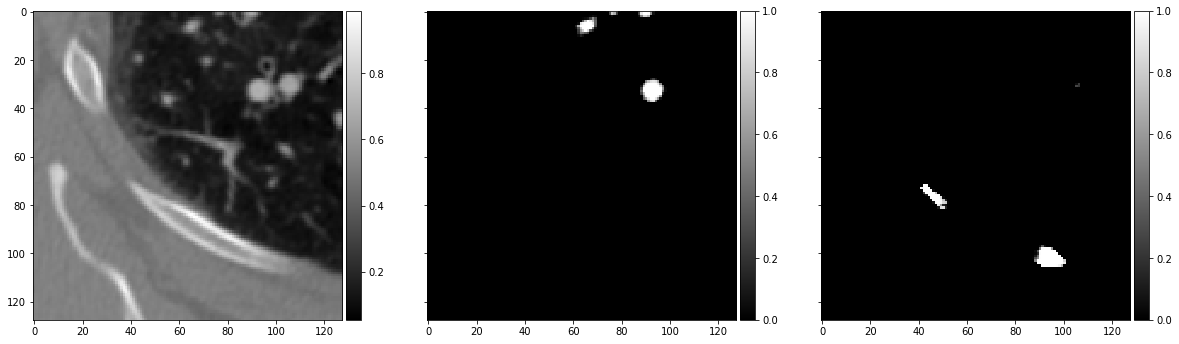

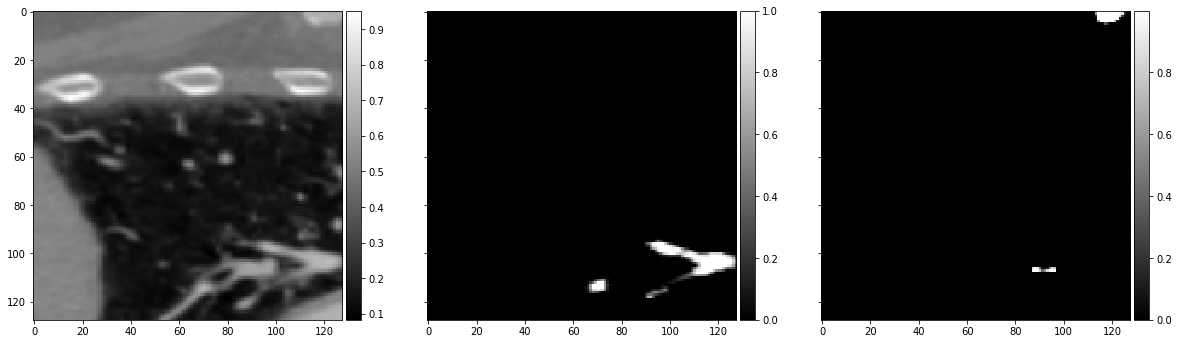

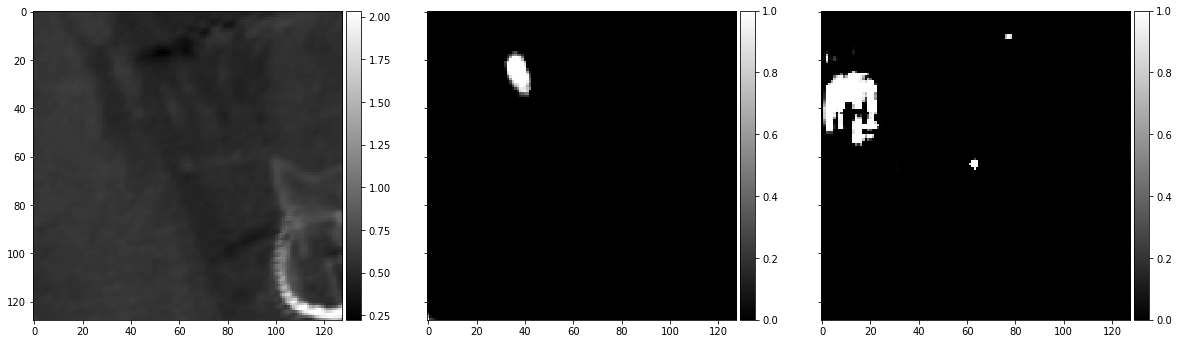

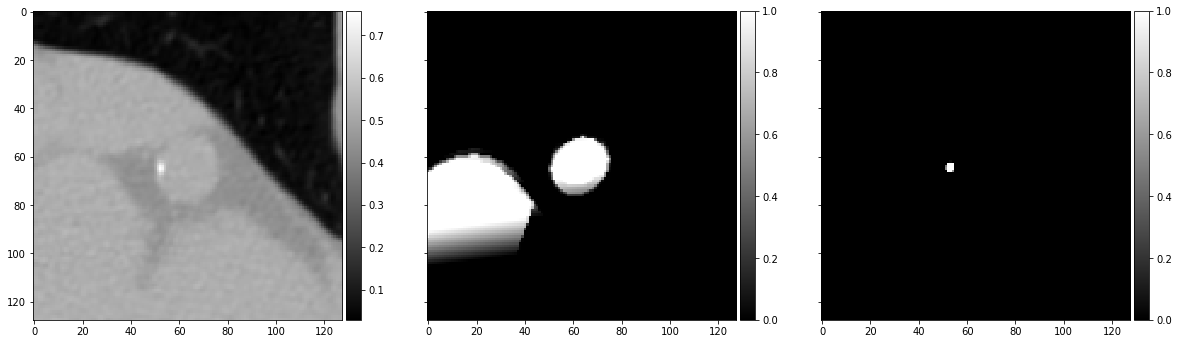

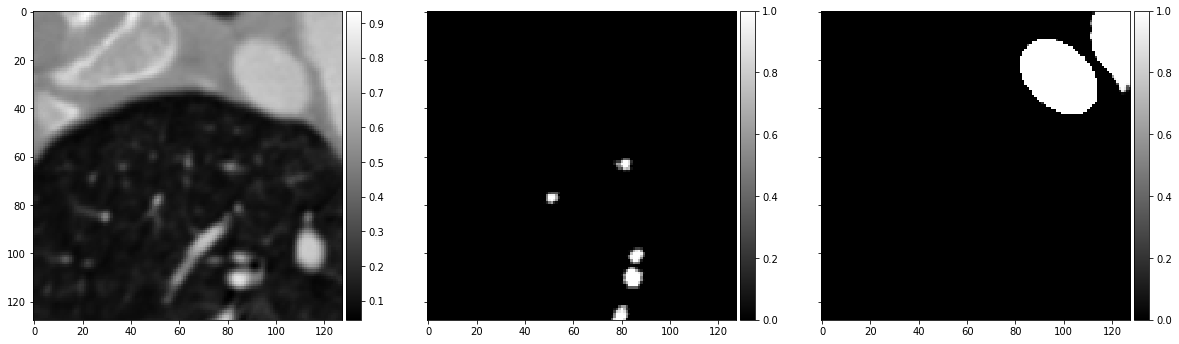

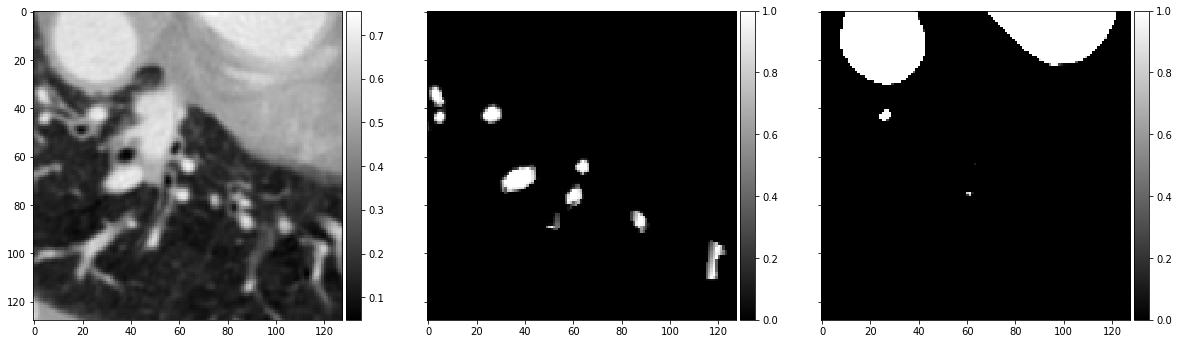

In [16]:
N=f_test.root.X.shape[0]
n=2 
for j in range(20):
    i = np.random.randint(N)
    xb = util.crop_center_nd(f_test.root.X[i:i+n], 
                                crop_dims,crop_dims)
    yb = util.crop_center_nd(f_test.root.Y[i:i+n],
                                crop_dims, crop_dims)
    ypred = sess.run(yclass,{x:xb,y:yb})
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(xb[0,:,:,0],ax1)
    implot(yb[0,:,:,0],ax2)
    implot(ypred[0,:,:,0],ax3)
    plt.tight_layout
    plt.show()

In [19]:
saver = tf.train.Saver()
saver.save(sess,'./models/i2i/i2i')

'./models/i2i/i2i'

In [5]:
saver = tf.train.Saver()
saver.restore(sess,'./models/i2i/i2i')

INFO:tensorflow:Restoring parameters from ./models/i2i/i2i


(276, 512, 512)


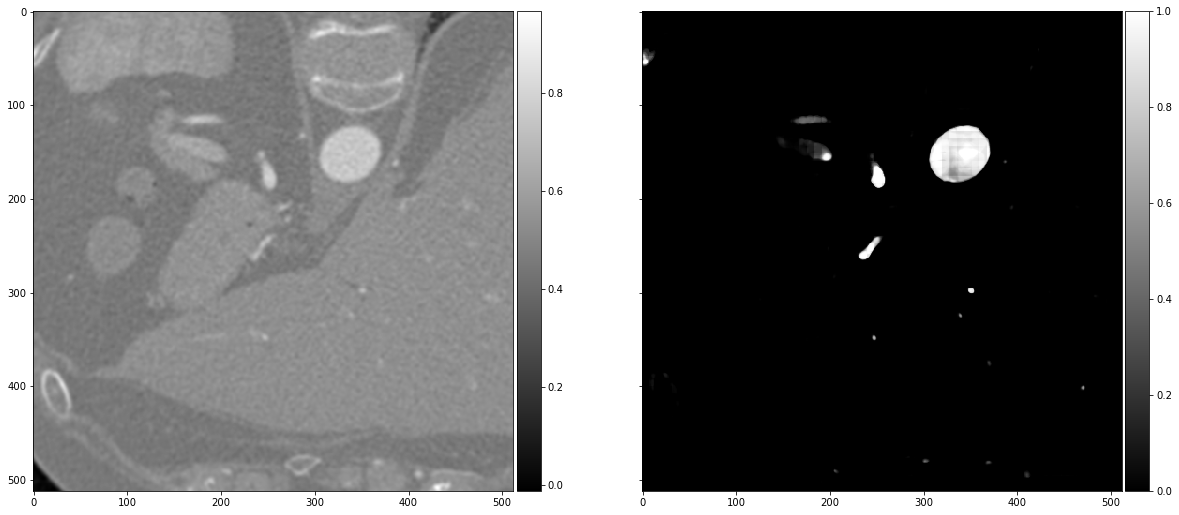

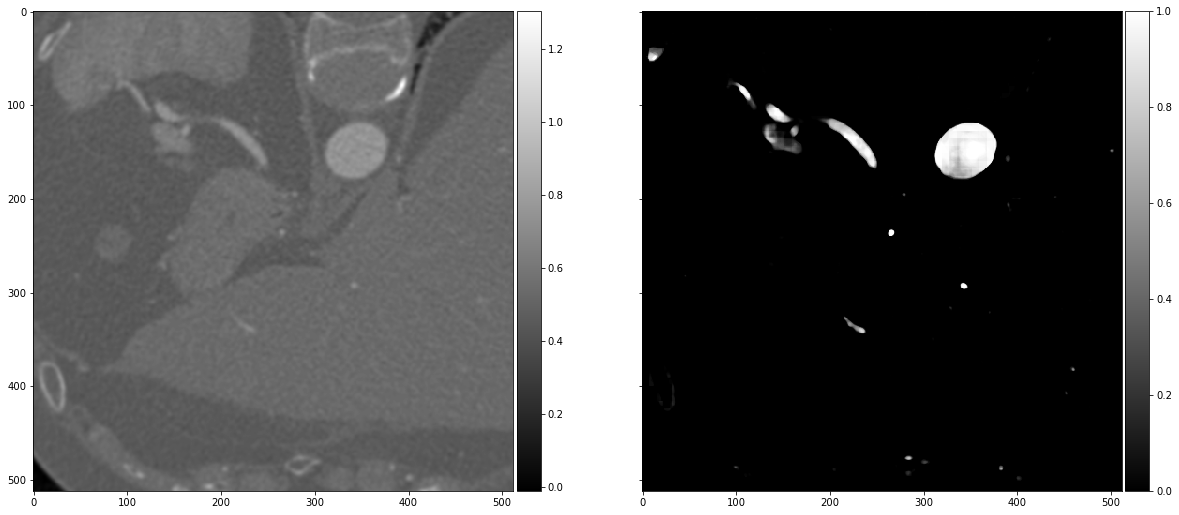

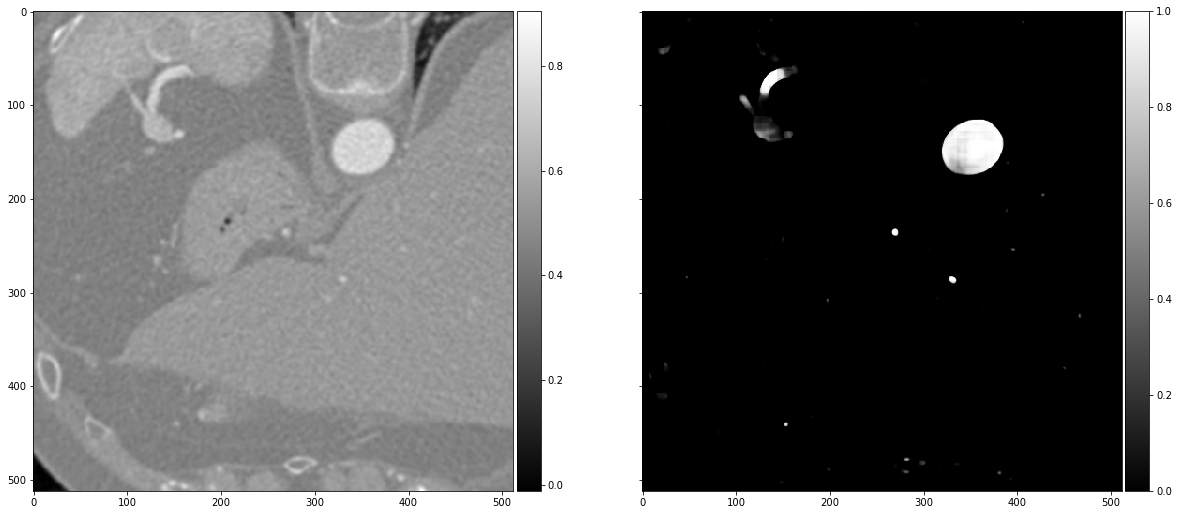

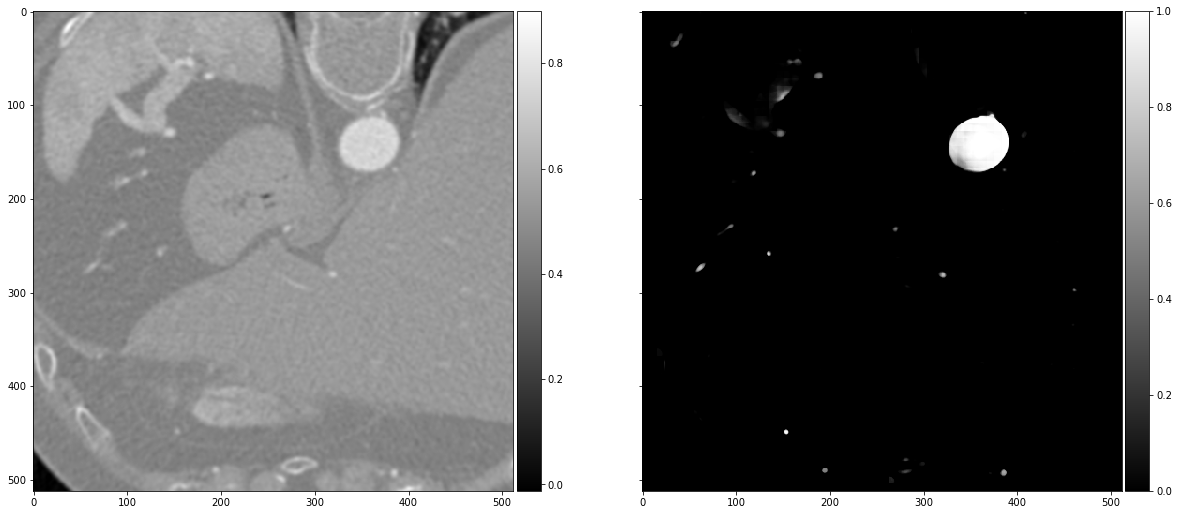

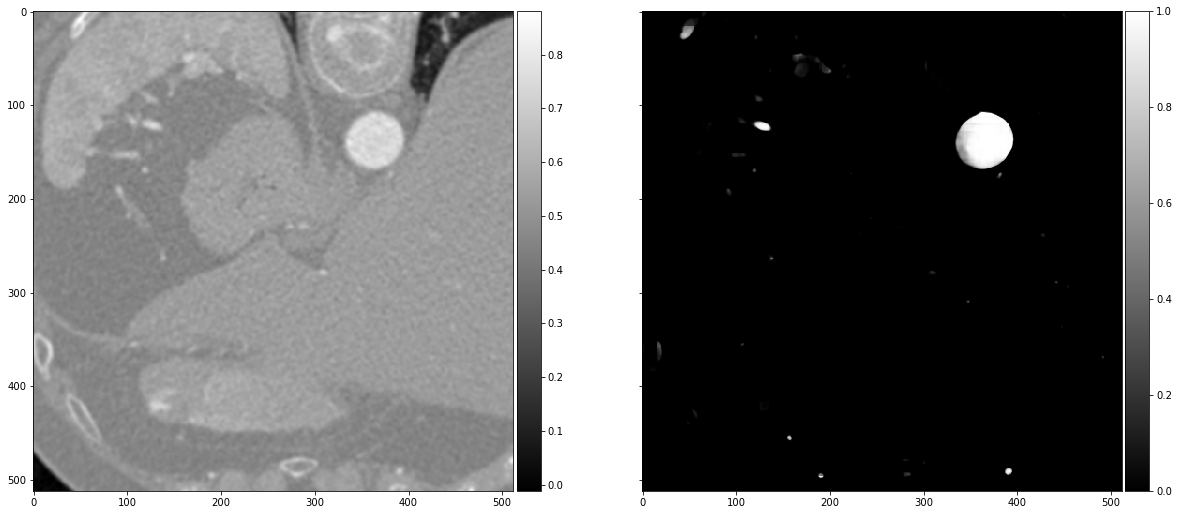

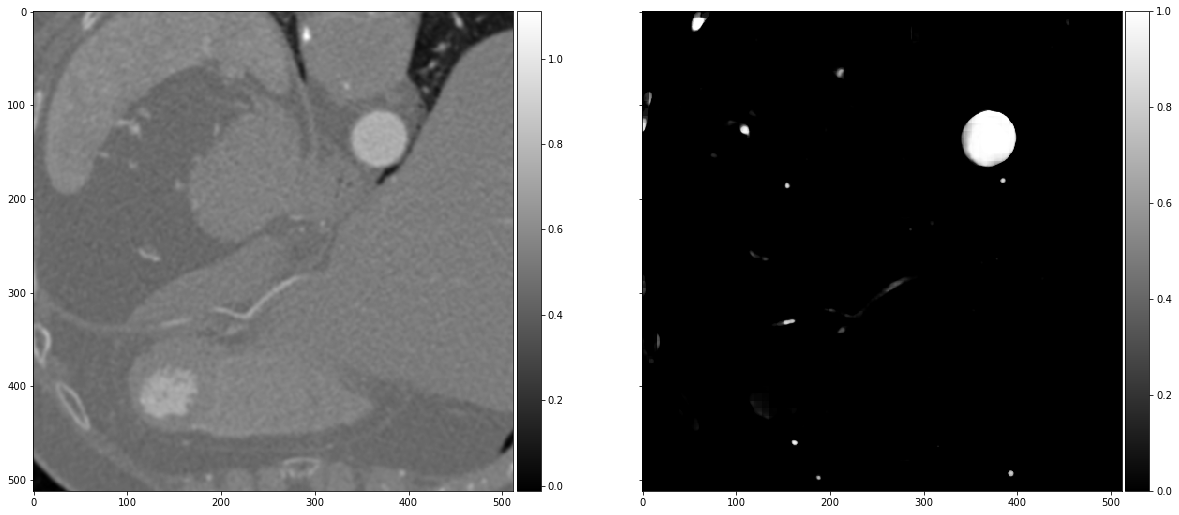

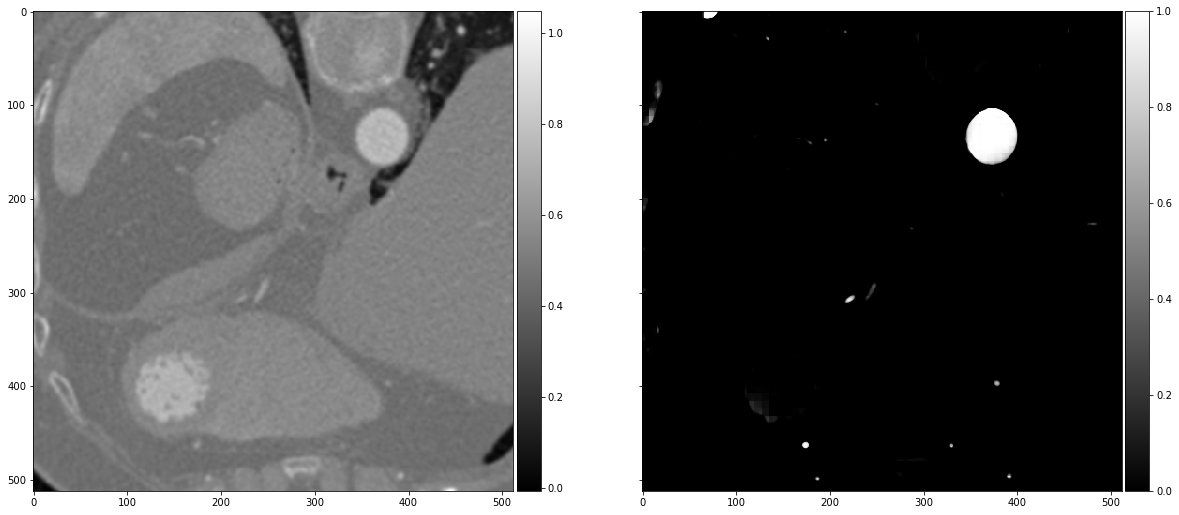

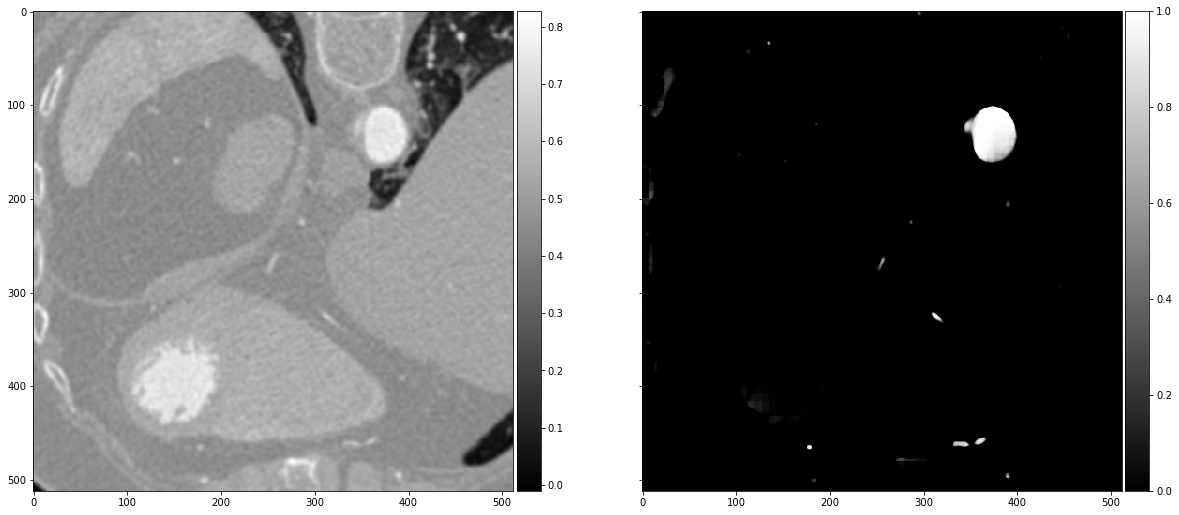

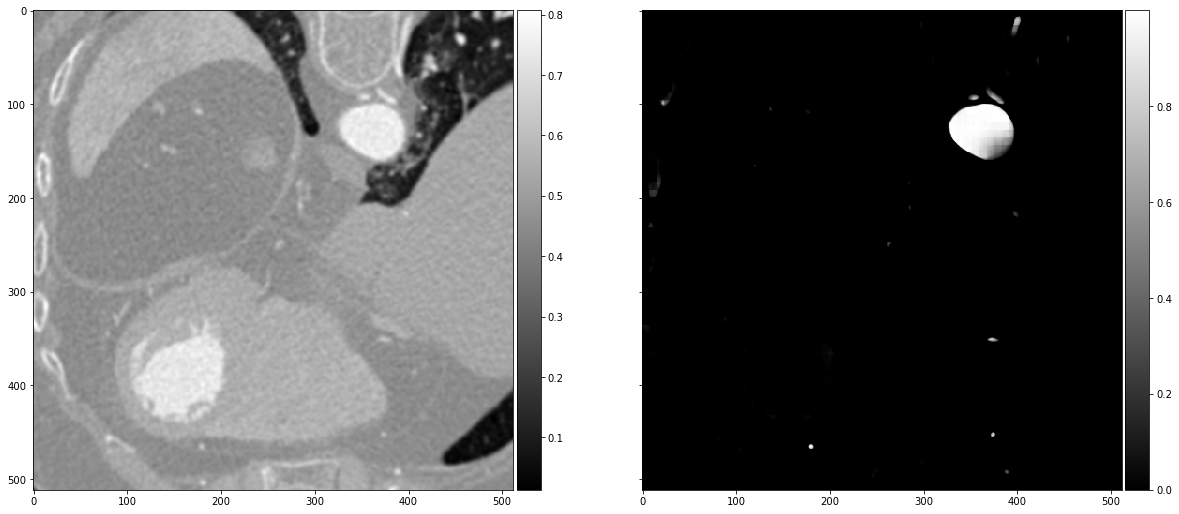

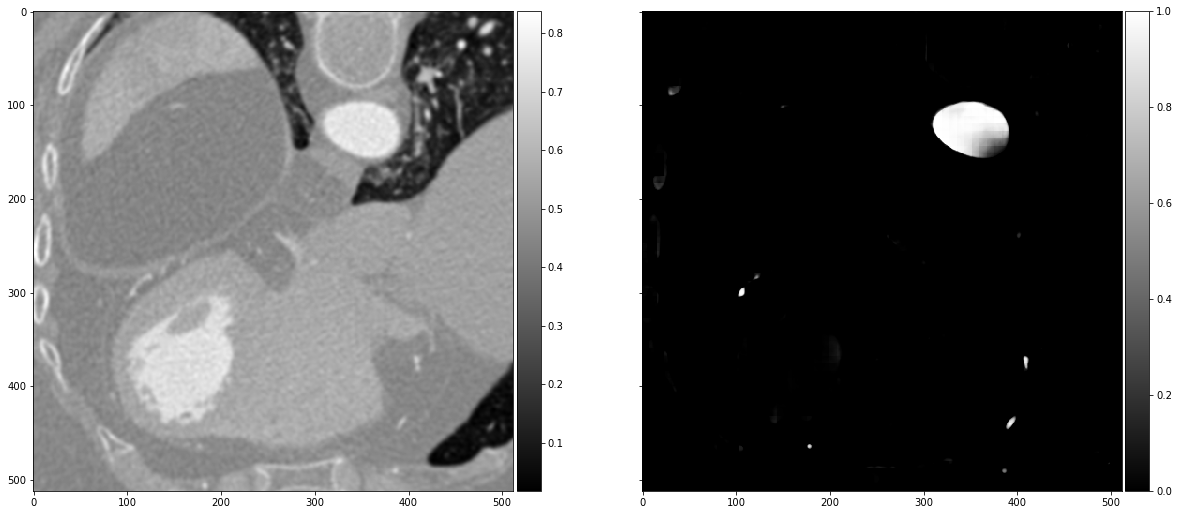

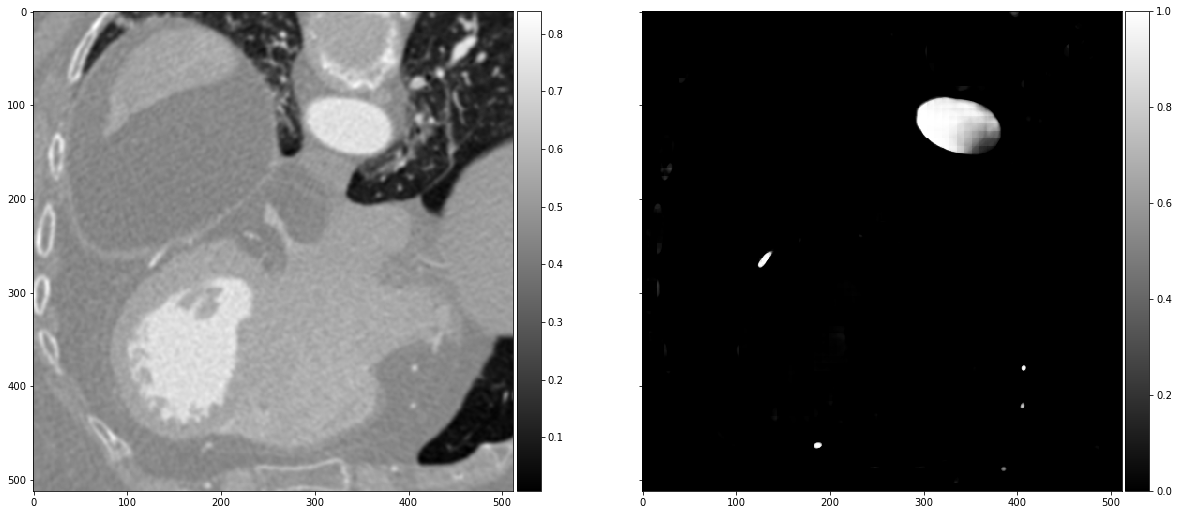

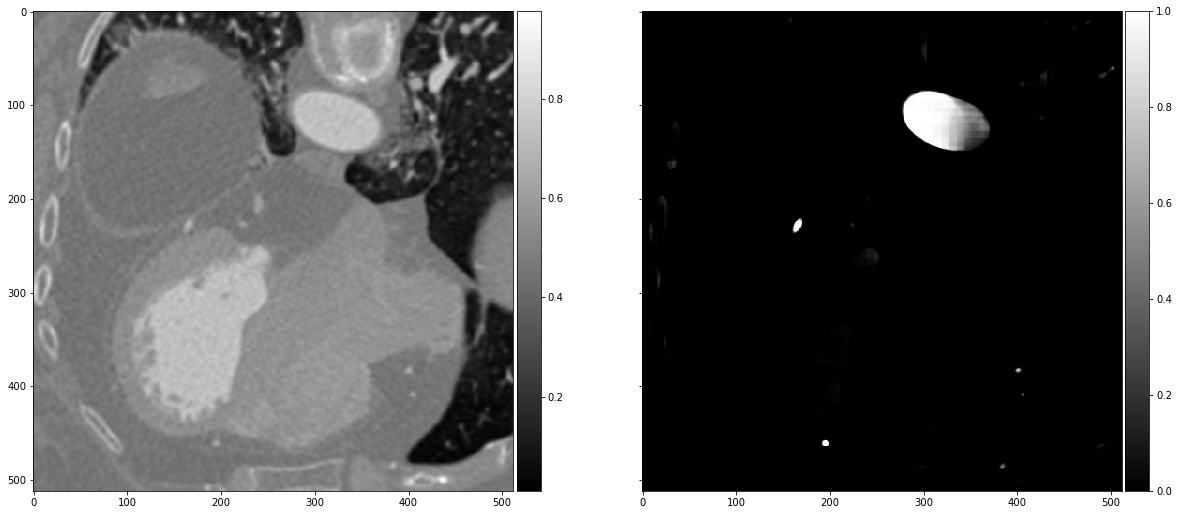

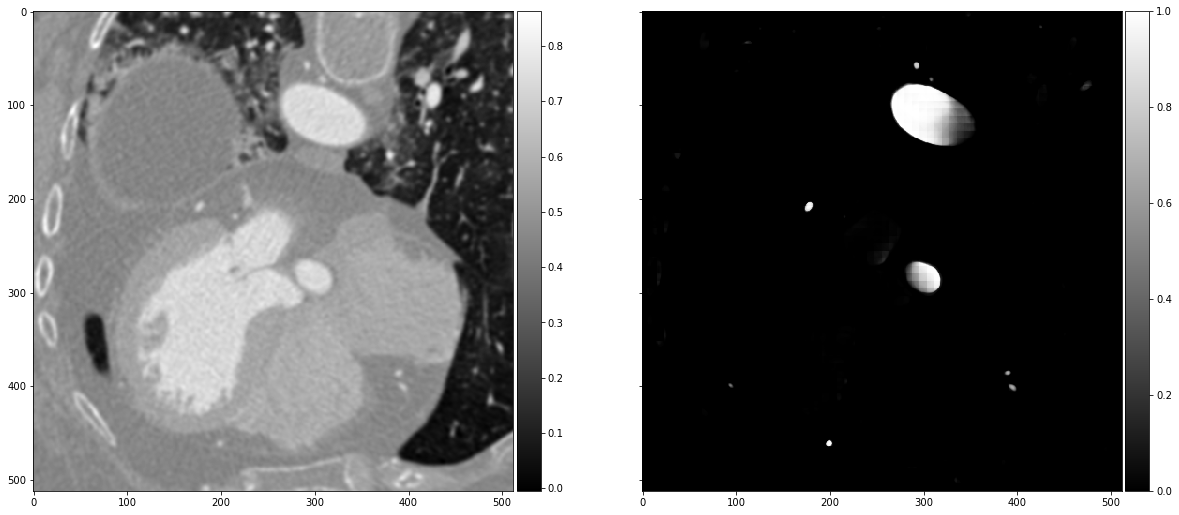

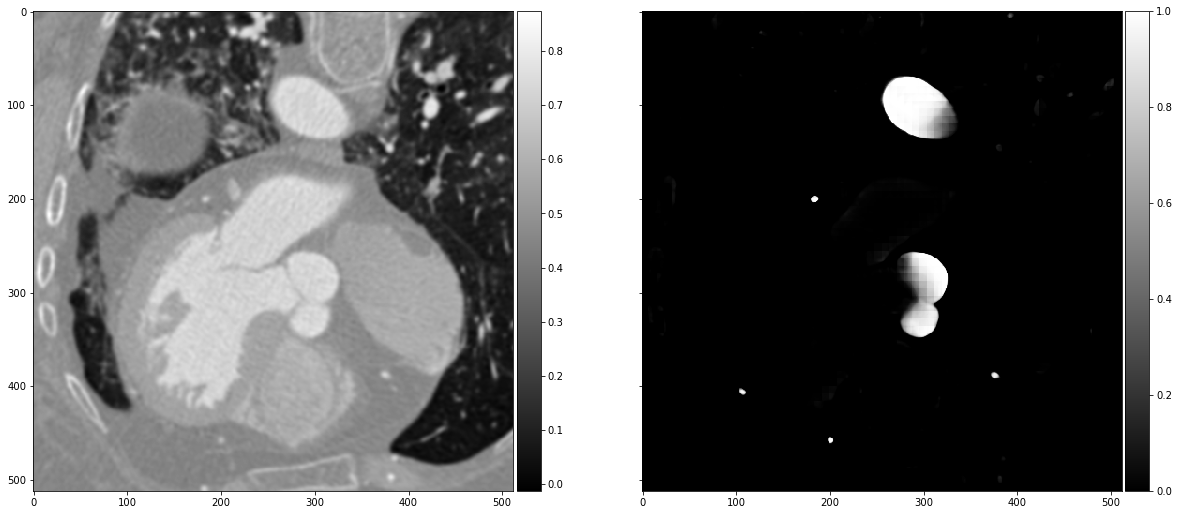

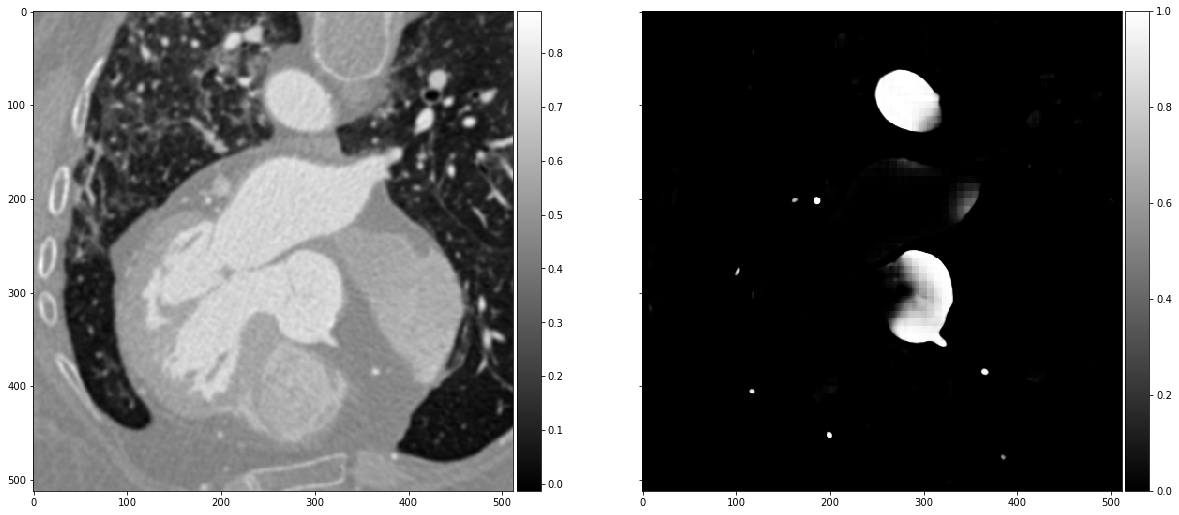

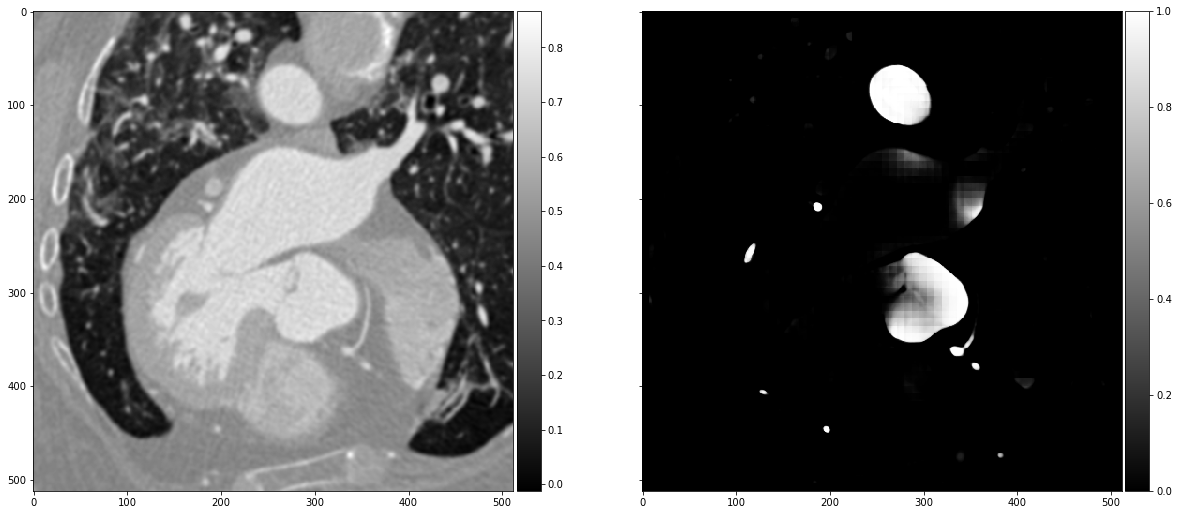

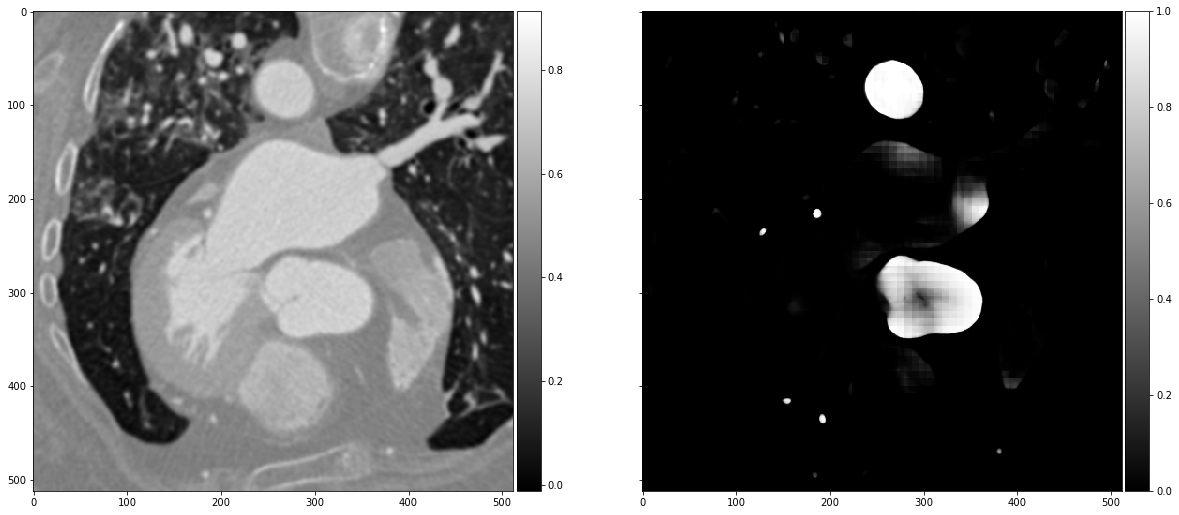

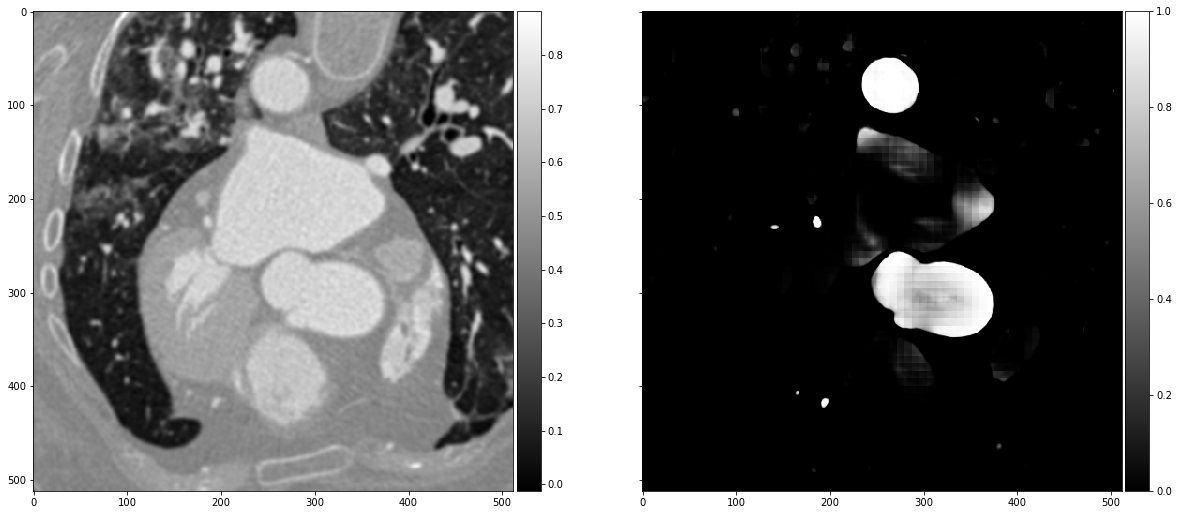

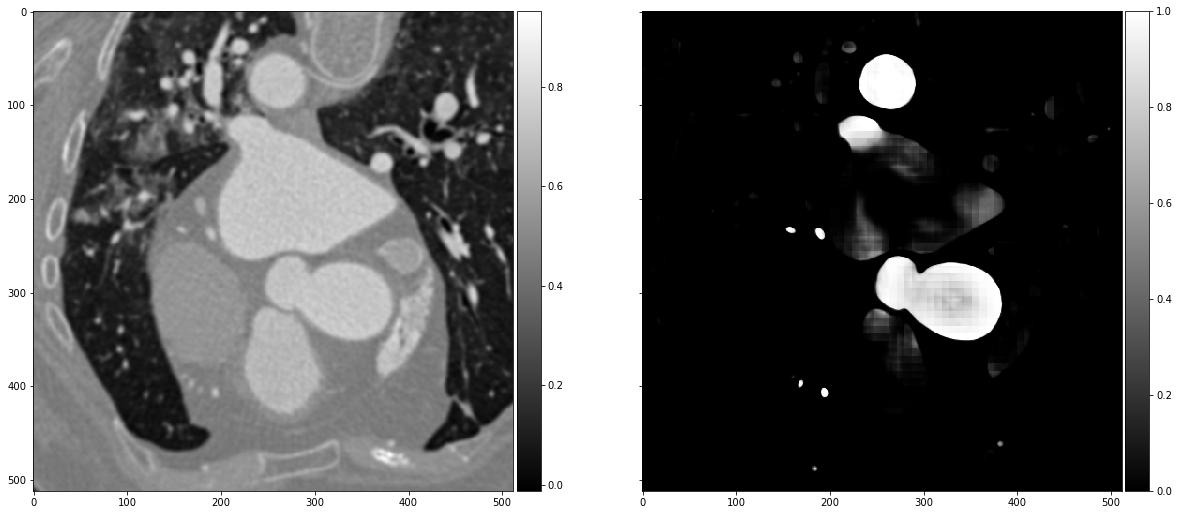

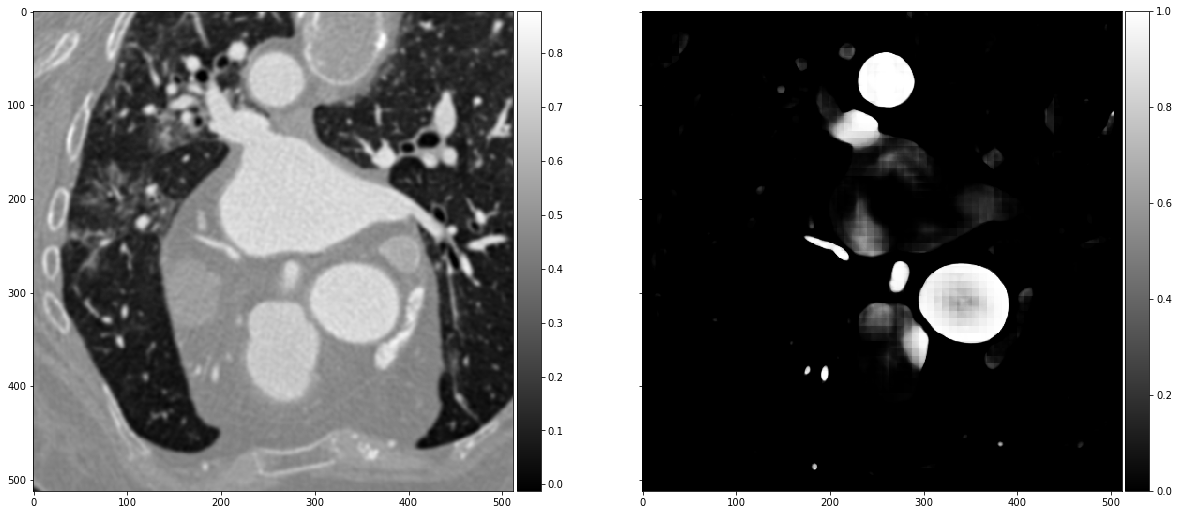

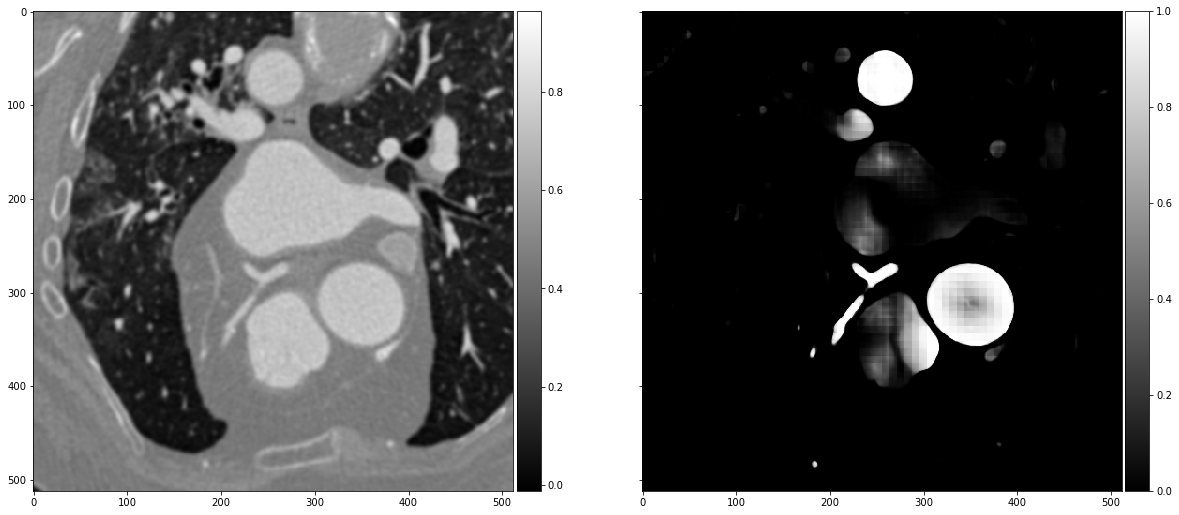

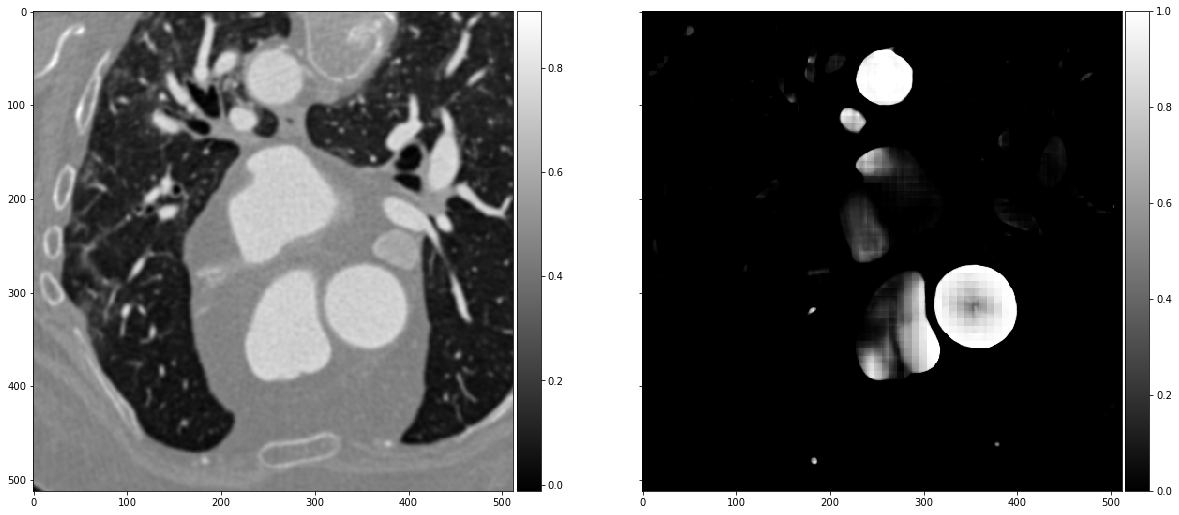

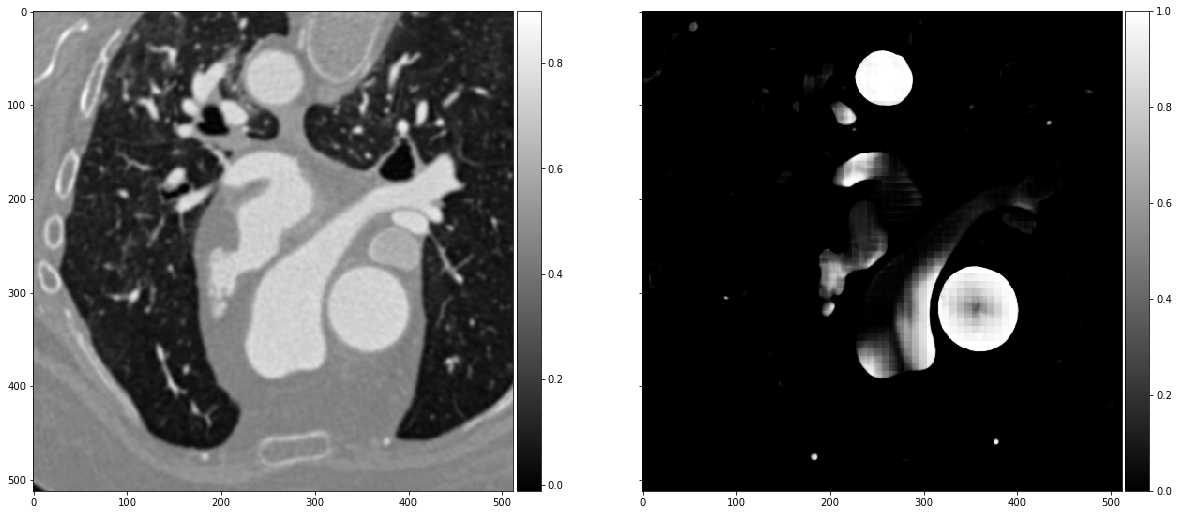

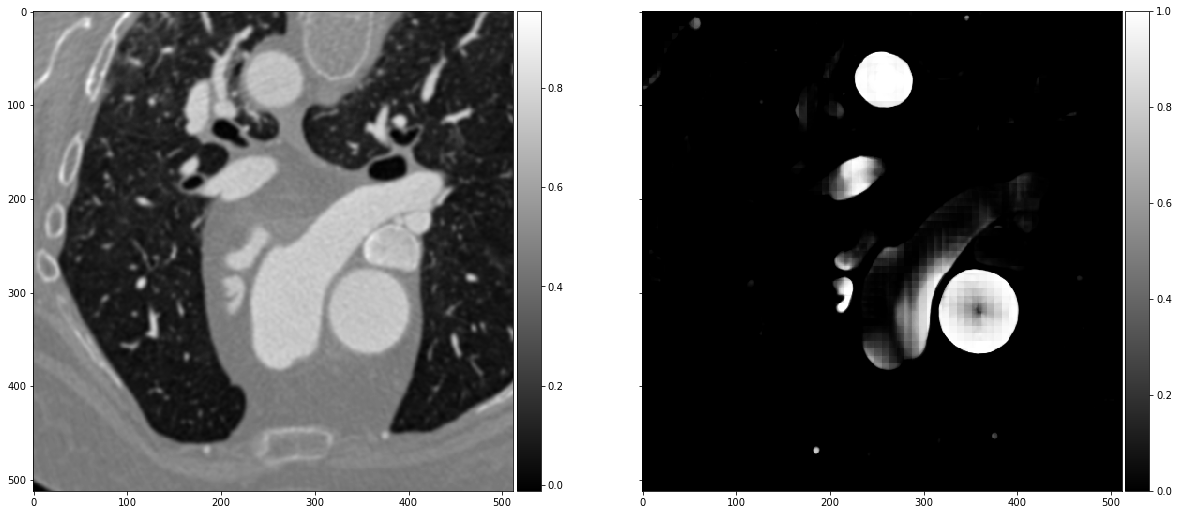

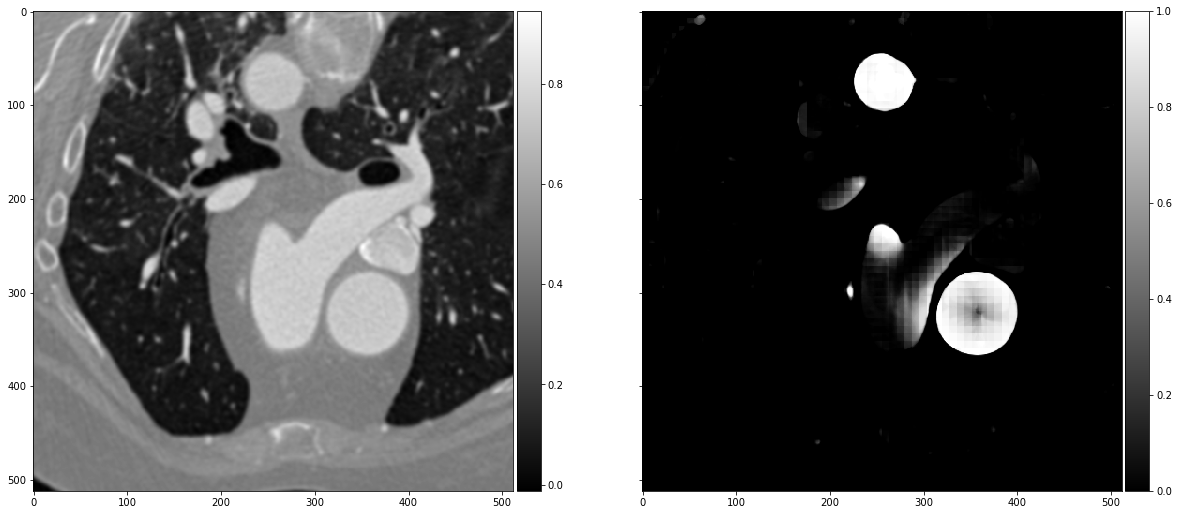

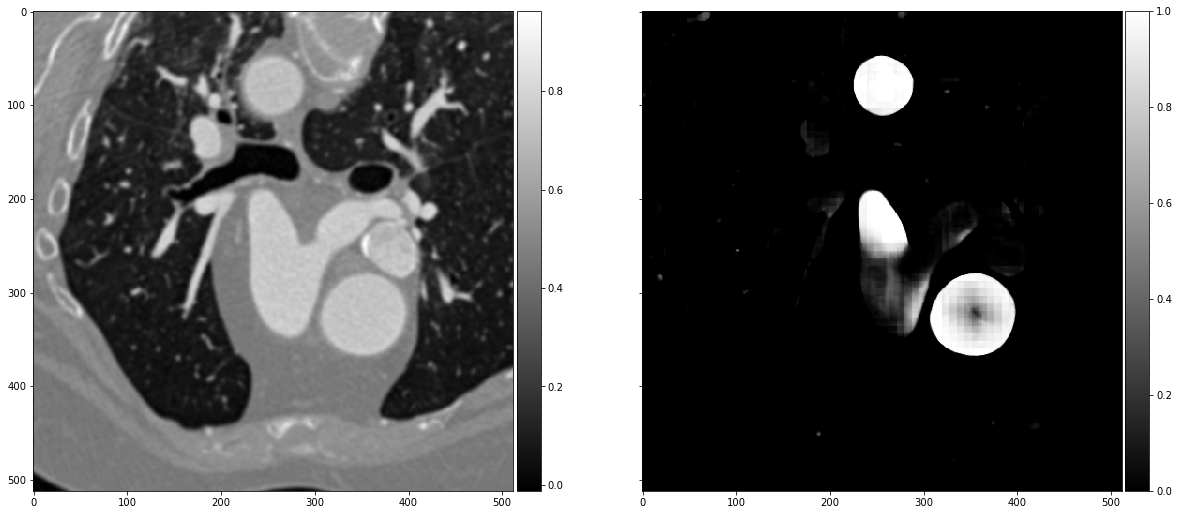

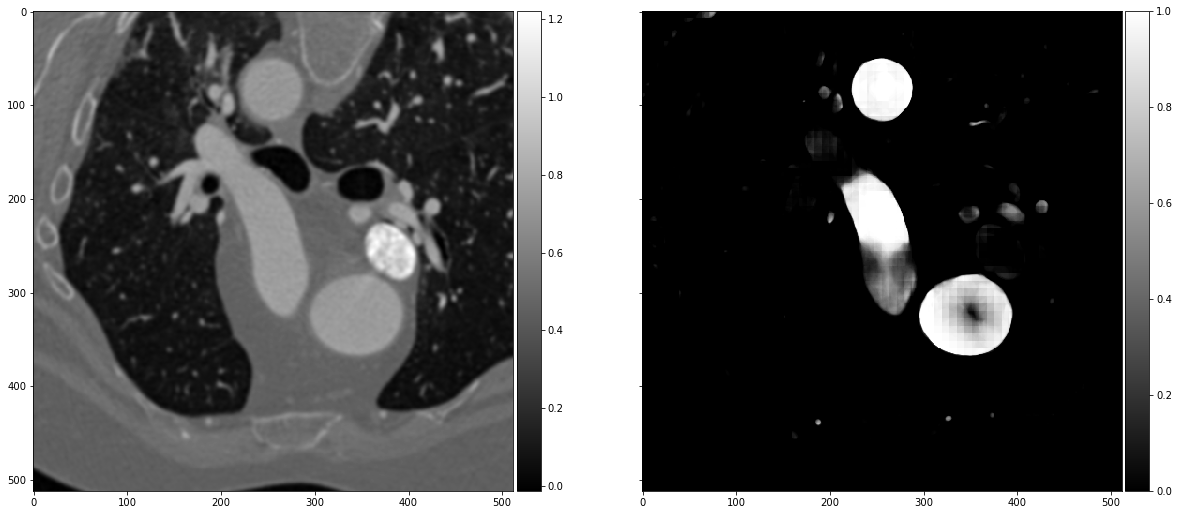